## Initialization

In [1]:
!pip install -e C:\Users\ID\.bitbucket\cea\Wrapd 
!pip install numpy
!pip install matplotlib

Obtaining file:///C:/Users/ID/.bitbucket/cea/Wrapd
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Checking if build backend supports build_editable: started
  Checking if build backend supports build_editable: finished with status 'done'
  Getting requirements to build editable: started
  Getting requirements to build editable: finished with status 'done'
  Installing backend dependencies: started
  Installing backend dependencies: finished with status 'done'
  Preparing editable metadata (pyproject.toml): started
  Preparing editable metadata (pyproject.toml): finished with status 'done'
  Building editable for CEA-Wrapd (pyproject.toml): started
  Building editable for CEA-Wrapd (pyproject.toml): finished with status 'done'
  Created wheel for CEA-Wrapd: filename=CEA_Wrapd-1.6.1-0.editable-py3-none-any.whl size=21875 sha256=380de4ffc92c188a9350693903e47240681a9d7d8d5d368cb46727edbfb9c36d
  Stored in directory: C:\Users\ID\AppDa

In [3]:
import CEA_Wrapd as cea
import numpy as np 
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import OttoCycle as oc
import copy
import csv


hept = 'C7H16,n-heptane'
oct = 'C8H18,isooctane'
a = "Air"

# 87 fuel
h87 = cea.Fuel(hept, wt_percent= 13.00) #n-heptane
o87 = cea.Fuel(oct, wt_percent= 87.00) #iso-octane
a100 = cea.Oxidizer(a, wt_percent= 100.00)
m87 = [h87,o87,a100]

# Basic Testing

In [7]:
#ideal vs real test
o_f = 13

ottoo = oc.Otto(p_kPa = 101, T_K = 300, d_kgm3 = 1.1731, v_m3 = 4.15E-5, CR= 10, gamma = 1.4, comp_eff= .85, exp_eff= .9)
ideal = oc.cyc_ideal(ottoo, IGCon= .287, QComb= 45E3, Cp= 1.005, comb_eff= .9, o_f= 12)
real = oc.cyc_real(ottoo, "realOtto", m, massf=True, o_f = o_f, reac_warming = True)
real_noWarm = oc.cyc_real(ottoo, "realOtto", m, massf=True, o_f = o_f, reac_temp = 300, report_comb=True)

ideal[3].curr_state()
real[3].curr_state()
real_noWarm[3].curr_state()

NameError: name 'm' is not defined

In [2]:
# Checking Power Calc
s1= oc.ThermoState(101, 300, 1.713, 4.15E-5)
s2= oc.ThermoState(101,300,1.1731,4.15E-4)
s3= oc.ThermoState(2537.0053,833.6069758,11.7305,4.15E-5)
s4= oc.ThermoState(14112.4470,4191.815931,11.7305,4.15E-5)
s5= oc.ThermoState(561.8266332, 1921.094375, 1.1731, 4.15E-5)
s6= s1 
states = [s1,s2,s3,s4,s5,s6]

#for i in states:
#    print(i.curr_state())
print(states[1].get_temperature())
print(states[1].get_density())
print(states[2].get_temperature())
print(states[3].get_temperature())
print(states[4].get_temperature())

oc.cyc_work(states, 10, .7175, 4, 0.000415)

300
1.1731
833.6069758
4191.815931
1921.094375


2.6968139391872805

# State Loop

### A/F and Displacement Parameters

In [3]:
# A/F & Displacement Looping
resolution = 200

IGC_air = .287 # kJ/kgK
Amb_Pres = 101 # kPa
Amb_Temp = 300 # K
CR = 10
CylCt = 4
gamma_air = 1.4
comp_eff = .85
exp_eff = .9

Amb_Dens = Amb_Pres / (IGC_air * Amb_Temp) # kg/m3

afvals= np.linspace(10,20, resolution)
dispvals = np.linspace(1500, 1800, resolution)
dispvals = dispvals/((10**2)**3)

data_cycles = np.empty((resolution,resolution), dtype= object)

for a in list(range(0,resolution)):
    for d in list(range(0,resolution)):
        cylvol = dispvals[d] / CylCt
        vol = cylvol/CR
        Ot= oc.Otto(Amb_Pres, Amb_Temp, Amb_Dens, vol, CR, gamma_air, comp_eff, exp_eff)
        cy= oc.cyc_real(Ot, "AFvsDISP", m87, True, afvals[a], reac_warming= False, report_comb= True)
        data_cycles[a][d] = cy      



## Work Calculations and Trade Studies

In [4]:
# Work Calculation
Cp = 1.005
Cv = Cp/gamma_air
CylCt = 4

data_AfDispWork = np.empty((resolution,resolution), dtype= float)

for a in list(range(0, resolution)):
    for d in list(range(0, resolution)):
        data_AfDispWork[a][d] = oc.cyc_work(data_cycles[a][d], CR, Cv, CylCt, dispvals[d]/CylCt)


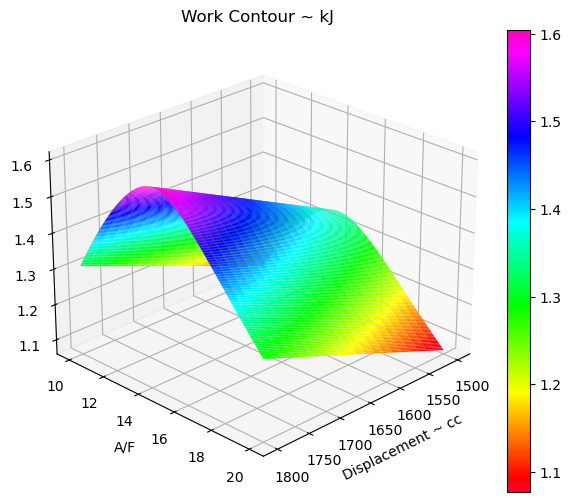

In [18]:
#Plotting Work
dispv, afv  = np.meshgrid(dispvals, afvals)

fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111, projection='3d')
contours = ax.plot_surface(X= dispv * 1E6, Y= afv, Z= data_AfDispWork, rstride = 1, cmap = 'gist_rainbow')
#ax.plot_surface(afvals, dispvals, data_AfDispWork)
ax.set_ylabel("A/F")
ax.set_xlabel("Displacement ~ cc")
#ax.set_zlabel("Work output ~ kJ")
ax.view_init(25, 45)
plt.title("Work Contour ~ kJ")
cbar = plt.colorbar(contours, ax=ax, pad=0.02)




In [108]:
test = np.empty(resolution, dtype = object)
for d in list(range(0,resolution-1)):
        cylvol = dispvals[d] / CylCt
        vol = cylvol/CR
        Ot= oc.Otto(Amb_Pres, Amb_Temp, Amb_Dens, vol, CR, gamma_air, comp_eff, exp_eff)
        cy= oc.cyc_real(Ot, "AFvsDISP", m87, True, 20, reac_warming= False, report_comb= True)
        test[d] = oc.cyc_work(cy, CR, Cv, CylCt, dispvals[d]/CylCt)

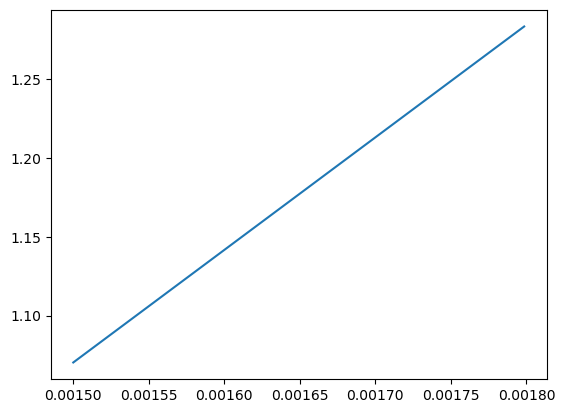

In [109]:
plt.plot(dispvals, test)

In [110]:
section_af_d1500_W = np.empty(resolution, dtype = object)
for a in list(range(0,resolution)):
        cylvol = .0015 / CylCt
        vol = cylvol/CR
        Ot= oc.Otto(Amb_Pres, Amb_Temp, Amb_Dens, vol, CR, gamma_air, comp_eff, exp_eff)
        cy= oc.cyc_real(Ot, "AFvsDISP", m87, True, afvals[a], reac_warming= False, report_comb= True)
        section_af_d1500_W[a] = oc.cyc_work(cy, CR, Cv, CylCt, cylvol)

section_af_d1800_W = np.empty(resolution, dtype = object)
for a in list(range(0,resolution)):
        cylvol = .0018 / CylCt
        vol = cylvol/CR
        Ot= oc.Otto(Amb_Pres, Amb_Temp, Amb_Dens, vol, CR, gamma_air, comp_eff, exp_eff)
        cy= oc.cyc_real(Ot, "AFvsDISP", m87, True, afvals[a], reac_warming= False, report_comb= True)
        section_af_d1800_W[a] = oc.cyc_work(cy, CR, Cv, CylCt, cylvol)


85


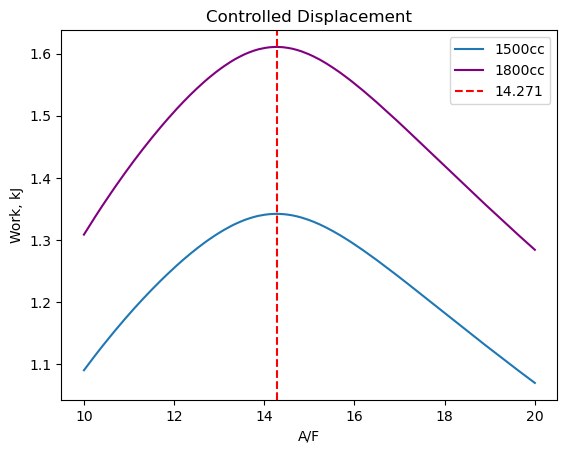

In [111]:
plt.plot(afvals, section_af_d1500_W, label = "1500cc")
plt.plot(afvals, section_af_d1800_W, label = "1800cc", color = 'purple')

plt.title("Controlled Displacement")
plt.xlabel("A/F")
plt.ylabel("Work, kJ")

max_index = np.argmax(np.array(section_af_d1500_W, dtype = float))
print(max_index)

plt.axvline(x = afvals[max_index], color='red', linestyle='--', label = round(afvals[max_index],3))
plt.legend()

## (Brake) Specific Fuel Consumption

In [20]:
CylCt = 4

Cp = 1.005
Cv = Cp/gamma_air

data_AfDispSFC = np.empty((resolution,resolution), dtype= float)

for a in list(range(0, resolution)):
    for d in list(range(0, resolution)):
        # = Cylinder Ct * Mass of Air / (air/fuel) / Total Work
            # Total Reactant = Air + Fuel
            # Mass Fuel = Mass Air / (A/F) --> Mass Fuel = (Total Reactant - Mass Fuel)/(A/F)
                # --> Mass Fuel + Mass Fuel / (A/F) = React / (A/F) --> Mass Fuel ( 1 + 1/(A/F)) = React / (A/F) 
                # --> Mass Fuel = React / ( A/F * (1 + 1/(A/F)))
        data_AfDispSFC[a][d] =  CylCt * (data_cycles[a][d][1].get_volume() * data_cycles[a][d][1].get_density()) / (afvals[a]  * ( 1 + 1/afvals[a])) / oc.cyc_work(data_cycles[a][d], CR, Cv, CylCt, dispvals[d]/CylCt)

eff_drivetrain = .8

data_AfDispBSFC = data_AfDispSFC / eff_drivetrain

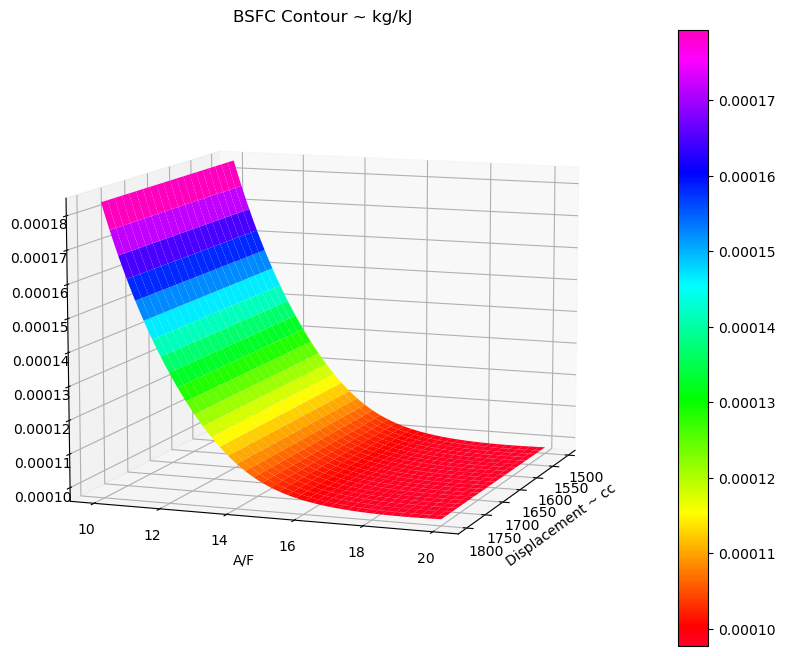

In [23]:
#Plotting BSFC
dispv, afv  = np.meshgrid(dispvals, afvals)

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='3d')
contours = ax.plot_surface(dispv * 1E6, afv, data_AfDispBSFC, rstride = 5, cmap = 'gist_rainbow')
#ax.plot_surface(afvals, dispvals, data_AfDispWork)
ax.set_title("BSFC Contour ~ kg/kJ")
ax.set_ylabel("A/F")
ax.set_xlabel("Displacement ~ cc")
#ax.set_zlabel("BSFC ~ kg/kJ")
#ax.set_zlim3d(4,6)
ax.view_init(10, 20)
cbar = plt.colorbar(contours, ax=ax)

In [114]:
section_af_d1500_SFC = np.empty(resolution, dtype = object)
for a in list(range(0,resolution)):
        cylvol = .0015 / CylCt
        vol = cylvol/CR
        Ot= oc.Otto(Amb_Pres, Amb_Temp, Amb_Dens, vol, CR, gamma_air, comp_eff, exp_eff)
        cy= oc.cyc_real(Ot, "AFvsDISP", m87, True, afvals[a], reac_warming= False, report_comb= True)
        section_af_d1500_SFC[a] = CylCt * (cy[1].get_volume() * cy[1].get_density()) / (afvals[a]  * ( 1 + 1/afvals[a])) / oc.cyc_work(cy, CR, Cv, CylCt, cylvol)


section_af_d1800_SFC = np.empty(resolution, dtype = object)
for a in list(range(0,resolution)):
        cylvol = .0018 / CylCt
        vol = cylvol/CR
        Ot= oc.Otto(Amb_Pres, Amb_Temp, Amb_Dens, vol, CR, gamma_air, comp_eff, exp_eff)
        cy= oc.cyc_real(Ot, "AFvsDISP", m87, True, afvals[a], reac_warming= False, report_comb= True)
        section_af_d1800_SFC[a] = CylCt * (cy[1].get_volume() * cy[1].get_density()) / (afvals[a]  * ( 1 + 1/afvals[a])) / oc.cyc_work(cy, CR, Cv, CylCt, cylvol)


179


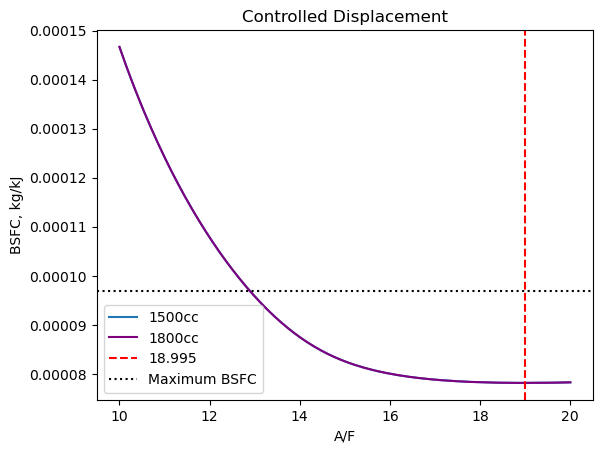

In [115]:
plt.plot(afvals, section_af_d1500_SFC, label = "1500cc")
plt.plot(afvals, section_af_d1800_SFC, label = "1800cc", color = 'purple')

plt.title("Controlled Displacement")
plt.xlabel("A/F")
plt.ylabel("BSFC, kg/kJ")

max_index = np.argmin(np.array(section_af_d1500_SFC, dtype = float))
print(max_index)

plt.axvline(x = afvals[max_index], color='red', linestyle='--', label = round(afvals[max_index],3))
plt.axhline(y = 9.7E-5, color = "black", linestyle=":", label = "Maximum BSFC")
plt.legend()

## Normalized Comparison of SFC and Work

In [116]:
print(1550E-6)

0.00155


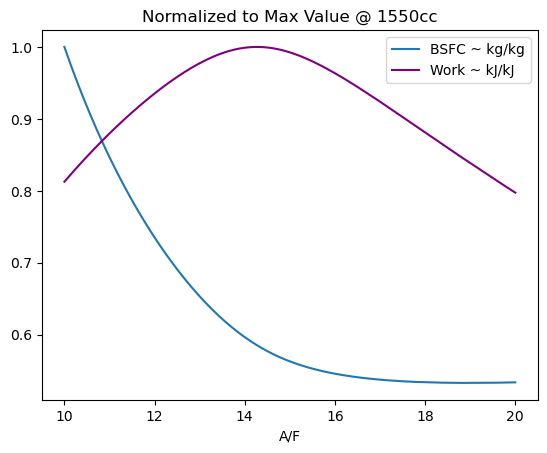

In [118]:
totdisp = 1550E-6

section_af_d1550_W = np.empty(resolution, dtype = object)
for a in list(range(0,resolution)):
        cylvol = totdisp / CylCt
        vol = cylvol/CR
        Ot= oc.Otto(Amb_Pres, Amb_Temp, Amb_Dens, vol, CR, gamma_air, comp_eff, exp_eff)
        cy= oc.cyc_real(Ot, "AFvsDISP", m87, True, afvals[a], reac_warming= False, report_comb= True)
        section_af_d1550_W[a] = oc.cyc_work(cy, CR, Cv, CylCt, cylvol)

section_af_d1550_SFC = np.empty(resolution, dtype = object)
for a in list(range(0,resolution)):
        cylvol = totdisp / CylCt
        vol = cylvol/CR
        Ot= oc.Otto(Amb_Pres, Amb_Temp, Amb_Dens, vol, CR, gamma_air, comp_eff, exp_eff)
        cy= oc.cyc_real(Ot, "AFvsDISP", m87, True, afvals[a], reac_warming= False, report_comb= True)
        section_af_d1550_SFC[a] = CylCt * (cy[1].get_volume() * cy[1].get_density()) / (afvals[a]  * ( 1 + 1/afvals[a])) / oc.cyc_work(cy, CR, Cv, CylCt, cylvol)


norm_af_d1550_SFC = section_af_d1550_SFC / max(section_af_d1550_SFC)
norm_af_d1550_W = section_af_d1550_W / max(section_af_d1550_W)

plt.plot(afvals, norm_af_d1550_SFC, label = "BSFC ~ kg/kg")
plt.plot(afvals, norm_af_d1550_W, label = "Work ~ kJ/kJ", color = 'purple')

plt.title("Normalized to Max Value @ 1550cc")
plt.xlabel("A/F")

#max_index = np.argmax(np.array(section_af_d1500, dtype = float))
#print(max_index)

#plt.axvline(x = afvals[max_index], color='red', linestyle='--', label = round(afvals[max_index],3))
plt.legend()

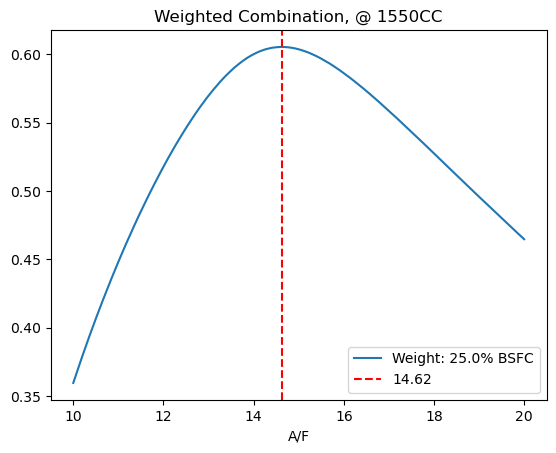

In [137]:
wgt_SFC = .25

wgt_norm_sum = -norm_af_d1550_SFC*wgt_SFC + norm_af_d1550_W*(1-wgt_SFC)
plt.plot(afvals, wgt_norm_sum, label = "Weight: " + str(wgt_SFC * 100) + "% BSFC")
plt.title("Weighted Combination, @ 1550CC")

max_index = np.argmax(np.array(wgt_norm_sum, dtype = float))
plt.axvline(x = afvals[max_index], color = 'red', linestyle = '--', label = round(afvals[max_index],2))
plt.xlabel("A/F")

plt.legend()

# Decided Air-fuel Analysis 

In [4]:
Amb_Pres = 101 #kPa
Amb_Temp = 300 #K
Amb_Dens = 1.1731 #kg/m3
gamma_air = 1.4
comp_eff = .85
exp_eff = .9

af_deci = 15.08 # actual
#af_deci = 15.2

disp_deci = 1550 * 1E-6
CylCt_deci = 4
CR_deci = 10
Cp = 1.005
Cv = Cp/gamma_air

cylvol = disp_deci / CylCt_deci
vol_deci = cylvol/CR_deci # per cylinder
Otto_deci= oc.Otto(Amb_Pres, Amb_Temp, Amb_Dens, vol_deci, CR_deci, gamma_air, comp_eff, exp_eff) # per cylinder
OtCyc_deci = oc.cyc_real(Otto_deci, "AFvsDISP", m87, True, af_deci, reac_warming= False, report_comb= True) # per cylinder


## Design Value Analysis
Temperature, Pressure, Emissions, etc.

In [5]:
t_design = OtCyc_deci[6].t 
p_design = OtCyc_deci[3].get_pressure()

emissions_design = OtCyc_deci[6].prod_c 

print(str(t_design) + " K Temperature during Combustion")
print(str(p_design) + " kPa Pressure @ TDC Combustion")
print(str(OtCyc_deci[6].h) + "kJ Enthalpy" )

pv = OtCyc_deci[4].get_pressure() / OtCyc_deci[4].get_density() - OtCyc_deci[2].get_pressure() / OtCyc_deci[2].get_density()
W = oc.cyc_work(OtCyc_deci, CR_deci, Cv, CylCt_deci, cylvol)
Q = OtCyc_deci[6].h - pv - W

print(str(Q) + " kJ Output Heat (check this)")

print(str(vol_deci * Amb_Dens) + " kg Mass in Chamber")

print('\n' + "Emissions")
print(emissions_design)


2734.1 K Temperature during Combustion
9398.099999999999 kPa Pressure @ TDC Combustion
594.18kJ Enthalpy
490.13383781482685 kJ Output Heat (check this)
4.5457625e-05 kg Mass in Chamber

Emissions
{'Ar': 0.01211, 'CO': 0.01675, 'CO2': 0.16576, 'H': 1e-05, 'HO2': 1e-05, 'H2': 0.00022, 'H2O': 0.08486, 'NO': 0.00545, 'NO2': 1e-05, 'N2': 0.70567, 'O': 0.00018, 'OH': 0.00276, 'O2': 0.0062}


### State 4 Analysis

In [6]:
print(str(OtCyc_deci[4].get_pressure()) + " kPa Pressure")
print(str(OtCyc_deci[4].get_density()) + " kg/m3 Density")
print(str(OtCyc_deci[4].get_temperature()) + " K Temperature")


374.1450999578823 kPa Pressure
1.1731 kg/m3 Density
1253.0283335092852 K Temperature


## Work and Power Analysis

In [7]:
print(str(W) + " kJ")
redline_rpm = 8000
Pow = W * redline_rpm / 60 / 2 # 60s to a minute, and only 2 powerstrokes per revolution
print(str(Pow) + " kW")

print(OtCyc_deci[3].curr_state())
print(OtCyc_deci[4].curr_state())




1.3741219708565364 kJ
91.60813139043576 kW
	p kPa	9398.099999999999	
	T K	2734.1	
	d kg/m3	11.731	
	v m3	3.875e-05
None
	p kPa	374.1450999578823	
	T K	1253.0283335092852	
	d kg/m3	1.1731	
	v m3	0.0003875
None


## Emissions Analysis

In [41]:
mass_cyl_air = Amb_Dens * cylvol *1000
mass_cyl = mass_cyl_air + (af_deci + 1) / af_deci
mass_cyl_fuel = mass_cyl_air / af_deci


emissions = OtCyc_deci[6]['prod_c']
print(emissions)

{'Ar': 0.01211, 'CO': 0.01675, 'CO2': 0.16576, 'H': 1e-05, 'HO2': 1e-05, 'H2': 0.00022, 'H2O': 0.08486, 'NO': 0.00545, 'NO2': 1e-05, 'N2': 0.70567, 'O': 0.00018, 'OH': 0.00276, 'O2': 0.0062}


In [31]:
CO = emissions['CO']
NO = emissions['NO']
NO2 = emissions['NO2']
NOX = NO + NO2

$ {Emission \over km} = {fuel mass \{g \} \over cycle} \times massfrac \{ {g_{element} \over g_{total}} \} \times {Revolutions \over kilometers} \times {1 cycle \times 4 cyl \over 2 rev} $

$ {Rev \over km} \approx RPM \times {60m \over 1hr} \times {1 \over kh/hr} $

In [42]:
mass_cyl_fuel

0.03014431366047745

In [33]:
Speed = [15, 25, 35, 45, 55, 65] #km/hr
for i in [0:length(Speed)] :
    NO2Emission[]


SyntaxError: invalid syntax (3747811451.py, line 2)

# Enthalpy and Etc.

In [48]:
# Enthalpy --> Heat Calc

data_AfDispEnth = np.empty((resolution,resolution), dtype= float)

for a in list(range(0, resolution)):
    for d in list(range(0, resolution)):
        data_AfDispEnth[a][d] = data_cycles[a][d][6].h

# del e (kJ/kg) = del h (kJ/kg) -  del v (m3/kg) p (kPa)  =  q + w 
#   --> q = del h - del (p v) - w 
# del h = pre to post combustion, noted by [comb6] ; del pv = pre comb [s3] to post power stroke [s5] ; w = the calculation

data_AfDispHeat = np.empty((resolution,resolution), dtype= float)
pv = np.empty((resolution,resolution), dtype = float)

for a in list(range(0, resolution)):
    for d in list(range(0, resolution)):
        pv[a][d] =  data_cycles[a][d][4].get_pressure() * 1 / data_cycles[a][d][4].get_density()  -  data_cycles[a][d][2].get_pressure() * 1 / data_cycles[a][d][2].get_density()
        data_AfDispHeat[a][d] = data_AfDispEnth[a][d] - pv[a][d] - data_AfDispWork[a][d]




In [45]:
#print(data_cycles[100][5][2].get_pressure())
#print(data_cycles[100][5][3].get_pressure())
#print(data_cycles[100][5][4].get_pressure())

#print(data_cycles[100][5][2].get_temperature())
#print(data_cycles[100][5][3].get_temperature())
#print(data_cycles[100][5][4].get_temperature())

#print(data_cycles[100][5][0].get_pressure() * data_cycles[100][5][0].get_volume() / data_cycles[100][5][0].get_temperature())
#print(data_cycles[100][5][1].get_pressure() * data_cycles[100][5][1].get_volume() / data_cycles[100][5][1].get_temperature())
#print(data_cycles[100][5][2].get_pressure() * data_cycles[100][5][2].get_volume() / data_cycles[100][5][2].get_temperature())
#print(data_cycles[100][5][3].get_pressure() * data_cycles[100][5][3].get_volume() / data_cycles[100][5][3].get_temperature())
#print(data_cycles[100][5][4].get_pressure() * data_cycles[100][5][4].get_volume() / data_cycles[100][5][4].get_temperature())
#print(data_cycles[100][5][5].get_pressure() * data_cycles[100][5][5].get_volume() / data_cycles[100][5][5].get_temperature())



1.2688442211055274e-05
0.00012688442211055277
0.00011470126840767111
0.00012959000469785518
0.0001125706073186667
1.2688442211055274e-05
